# **CSE552 Homework 5**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

* [github.com/Berkin99/MachineLearning](https://github.com/Berkin99/MachineLearning)

## **Part I: Electrical Grid Stability Simulated Data**
* Name : Electrical Grid Stability Simulated Data
* Link : https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data

The local stability analysis of the 4-node star system (electricity producer is in the center) implementing Decentral Smart Grid Control concept.
Dataset Characteristics

* Classification, Regression
* Feature Type = Real
* Instances = 10000
* Features = 12

The analysis is performed for different sets of input values using the methodology similar to that described in [SchÃ¤fer, Benjamin, et al. 'Taming instabilities in power grid networks by decentralized control.' The European Physical Journal Special Topics 225.3 (2016): 569-582.]. Several input values are kept the same: averaging time: 2 s; coupling strength: 8 s^-2; damping: 0.1 s^-1

## **Part II:  Train a multi-layer perceptron for this problem.**

* Use a one hidden layer perceptron as your base classifier to train an AdaBoost ensemble learner.
* Report your results.


FINAL TEST METRICS
Accuracy   : 0.948
Confusion  :
 [[ 667   57]
 [  47 1229]]
              precision    recall  f1-score   support

    unstable       0.93      0.92      0.93       724
      stable       0.96      0.96      0.96      1276

    accuracy                           0.95      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.95      0.95      0.95      2000



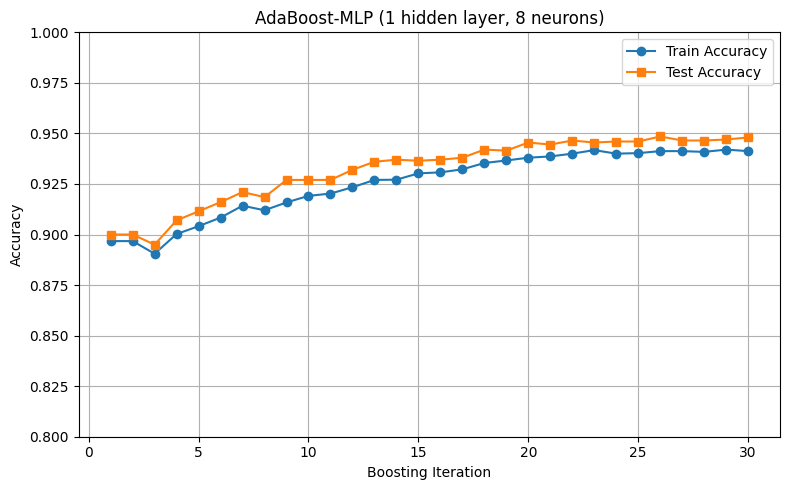

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

DATA_PATH = "Data_for_UCI_named.csv"

# 1. Load and preprocess
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=["stab", "stabf"]).values
y = LabelEncoder().fit_transform(df["stabf"])  # 0 = unstable, 1 = stable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 2. AdaBoost-MLP Ensemble
class AdaBoostMLP:
    """
    Manual AdaBoost implementation with MLP (no native sample_weight support).
    """
    def __init__(self, n_estimators=30, learning_rate=0.2, hidden=8, max_iter=50, random_state=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.hidden = hidden
        self.max_iter = max_iter
        self.random_state = random_state
        self.models = []
        self.alphas = []

    def _build_mlp(self, seed):
        return MLPClassifier(
            hidden_layer_sizes=(self.hidden,),
            max_iter=self.max_iter,
            solver="adam",
            tol=1e-4,
            n_iter_no_change=10,
            random_state=self.random_state + seed
        )

    def fit(self, X, y):
        n_samples = len(X)
        weights = np.ones(n_samples) / n_samples

        for m in range(self.n_estimators):
            # Weighted resampling
            idx = np.random.RandomState(self.random_state + m).choice(
                n_samples, n_samples, p=weights
            )
            mlp = self._build_mlp(m)
            mlp.fit(X[idx], y[idx])

            pred = mlp.predict(X)
            err = np.clip(np.dot(weights, pred != y) / weights.sum(), 1e-10, 1 - 1e-10)
            alpha = self.learning_rate * 0.5 * np.log((1 - err) / err)

            # Update weights
            weights *= np.exp(-alpha * (2 * (pred == y) - 1))
            weights /= weights.sum()

            self.models.append(mlp)
            self.alphas.append(alpha)
        return self

    def _aggregate(self, X, upto=None):
        upto = len(self.models) if upto is None else upto
        agg = sum(
            alpha * (2 * (model.predict(X) == 1) - 1)
            for model, alpha in zip(self.models[:upto], self.alphas[:upto])
        )
        return (agg >= 0).astype(int)

    def staged_scores(self, X, y):
        for t in range(1, len(self.models) + 1):
            yield accuracy_score(y, self._aggregate(X, upto=t))

    def predict(self, X):
        return self._aggregate(X)

# 3. Train, Evaluate, Plot

# Training
ada = AdaBoostMLP(n_estimators=30, learning_rate=0.2, hidden=8, max_iter=50, random_state=42)
ada.fit(X_train, y_train)

# Learning curves
train_acc = list(ada.staged_scores(X_train, y_train))
test_acc  = list(ada.staged_scores(X_test, y_test))

# Evaluation
y_pred = ada.predict(X_test)
print(f"Accuracy   : {accuracy_score(y_test, y_pred):.3f}")
print("Confusion  :\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["unstable", "stable"]))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc) + 1), train_acc, "o-", label="Train Accuracy")
plt.plot(range(1, len(test_acc) + 1), test_acc,  "s-", label="Test Accuracy")
plt.xlabel("Boosting Iteration")
plt.ylabel("Accuracy")
plt.title("AdaBoost-MLP (1 hidden layer, 8 neurons)")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Part III: Train a random decision forest where each decision in the forest is in turn is a trainable perceptron.**
This time instead of using a comparison decision at each node, train a perceptron for each node to
make the best decision. Report your results.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "Data_for_UCI_named.csv"

# 1. Load and preprocess
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=["stab", "stabf"]).values
y = LabelEncoder().fit_transform(df["stabf"])  # 0 = unstable, 1 = stable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Perceptron Tree Node
class PerceptronNode:
    def __init__(self, depth, max_depth, min_samples_leaf, feature_indices, random_state):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.feature_indices = np.array(feature_indices)
        self.random_state = random_state

        self.is_leaf = False
        self.leaf_class = None
        self.clf = None
        self.left = None
        self.right = None

    def fit(self, X, y, rng):
        # Stopping conditions
        if (self.depth >= self.max_depth or
            len(X) <= 2 * self.min_samples_leaf or
            len(np.unique(y)) == 1):
            self.is_leaf = True
            self.leaf_class = Counter(y).most_common(1)[0][0]
            return self

        # Fit perceptron to a random subset of features
        X_sub = X[:, self.feature_indices]
        self.clf = SGDClassifier(
            loss="log_loss",  # correct loss for logistic regression in latest sklearn
            penalty="l2",
            max_iter=200,
            tol=1e-3,
            random_state=self.random_state
        ).fit(X_sub, y)

        split = self.clf.predict(X_sub)  # 0/1 for left/right
        left_mask = (split == 0)
        right_mask = ~left_mask

        # If either side is too small, make leaf
        if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
            self.is_leaf = True
            self.leaf_class = Counter(y).most_common(1)[0][0]
            return self

        # Random subset for children
        next_features = lambda: rng.choice(
            X.shape[1], size=len(self.feature_indices), replace=False
        )

        self.left = PerceptronNode(self.depth + 1, self.max_depth, self.min_samples_leaf,
                                   next_features(), self.random_state + 1)
        self.right = PerceptronNode(self.depth + 1, self.max_depth, self.min_samples_leaf,
                                    next_features(), self.random_state + 2)

        self.left.fit(X[left_mask], y[left_mask], rng)
        self.right.fit(X[right_mask], y[right_mask], rng)
        return self

    def predict_one(self, x):
        if self.is_leaf:
            return self.leaf_class
        split = self.clf.predict(x[self.feature_indices].reshape(1, -1))[0]
        if split == 0:
            return self.left.predict_one(x)
        else:
            return self.right.predict_one(x)

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

# ---------------------------------------------
# 3. Perceptron Decision Tree
# ---------------------------------------------
class PerceptronTree:
    def __init__(self, max_depth=6, min_samples_leaf=20, max_features=0.7, random_state=0):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.root = None

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = max(1, int(self.max_features * X.shape[1]))
        feature_indices = rng.choice(X.shape[1], size=n_features, replace=False)

        self.root = PerceptronNode(
            depth=0,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            feature_indices=feature_indices,
            random_state=self.random_state
        ).fit(X, y, rng)
        return self

    def predict(self, X):
        return self.root.predict(X)

# ---------------------------------------------
# 4. Random Perceptron Forest (Ensemble)
# ---------------------------------------------
class RandomPerceptronForest:
    def __init__(self, n_trees=30, max_depth=6, min_samples_leaf=20, max_features=0.7, random_state=0):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_samples = len(X)
        self.trees = []
        for m in range(self.n_trees):
            # Bootstrap sample
            idx = rng.choice(n_samples, size=n_samples, replace=True)
            tree = PerceptronTree(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state + m
            )
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
        return self

    def predict(self, X):
        # Majority vote
        all_preds = np.vstack([t.predict(X) for t in self.trees])
        maj = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=all_preds)
        return maj

# ---------------------------------------------
# 5. Train and Evaluate
# ---------------------------------------------
forest = RandomPerceptronForest(
    n_trees=40,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.7,
    random_state=42
)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["unstable", "stable"]))



Accuracy: 0.8615
Confusion Matrix:
[[ 533  191]
 [  86 1190]]

Classification Report:
              precision    recall  f1-score   support

    unstable       0.86      0.74      0.79       724
      stable       0.86      0.93      0.90      1276

    accuracy                           0.86      2000
   macro avg       0.86      0.83      0.84      2000
weighted avg       0.86      0.86      0.86      2000



## **Conclusion**

The AdaBoost MLP model outperformed the Random Decision Forest (RDF) with perceptron splits, achieving higher accuracy (94.8% vs 86.2%) and better precision, recall, and f1-scores for both classes. In my opinion, AdaBoost MLP works better here because it combines many simple MLPs and focuses on correcting mistakes with each new model, making it highly effective for this classification problem. The RDF with perceptron splits is still a creative and interesting approach, but it is harder to optimize and tends to be less robust compared to AdaBoost with well-tuned MLPs. Overall, AdaBoost MLP is the more reliable and powerful choice for this dataset.
